In [2]:
# !pip install catboost
# !pip install spacy
# !python -m spacy download es_core_news_sm

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import os
import re

from catboost import CatBoostRegressor, Pool, cv
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import make_column_selector as selector
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score, RandomizedSearchCV, GridSearchCV, cross_val_predict
from sklearn.metrics import r2_score, make_scorer
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import StackingRegressor, RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
import spacy
from transformers import BertTokenizer, BertModel, BertForSequenceClassification, BertConfig
import torch
import torch.optim as optim
from geopy.distance import geodesic

import warnings
warnings.filterwarnings("ignore")

/opt/homebrew/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


ModuleNotFoundError: No module named 'catboost'

### Load Dataset

In [2]:
path = os.path.expanduser('~/data/train.pickle')
with open(path, 'rb') as f:
    train = pickle.load(f)

In [3]:
with open(os.path.expanduser('~/data/test_kaggle.pickle'), 'rb') as t:
    test = pickle.load(t)

In [4]:
def clean_columns(x):
    if isinstance(x, list):
        cols = ['size', 'bed', 'bath', 'price_per_sqm']
        x = [i.split(' ')[0] for i in x]
        return x
    else:
        x = str(x)
        x = x.split(' ')[0]
        return x


## Data Cleaning and Feature Engineering

In [6]:
def clean_text(text):
    cleaned_text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    cleaned_text = re.sub(r'\s+', ' ', cleaned_text)  # Remove extra whitespaces
    cleaned_text = cleaned_text.strip()  # Remove leading/trailing whitespaces
    cleaned_text = cleaned_text.lower()  # Convert to lowercase
    cleaned_text = cleaned_text.replace('\n', ' ') # remove new line
    return cleaned_text

In [7]:
d = pd.DataFrame(train)
locations = d.loc_string.unique().tolist()
locations
d1 = pd.DataFrame(test)
locations1 = d1.loc_string.unique().tolist()
locations1

['Barcelona - El Parc i la Llacuna del Poblenou',
 'Barcelona - Poblenou',
 'Barcelona - L´Antiga Esquerra de l´Eixample',
 'Barcelona - Sant Antoni',
 'Barcelona - Dreta de l´Eixample',
 'Barcelona - La Nova Esquerra de l´Eixample',
 'Barcelona - Fort Pienc',
 'Barcelona - Sagrada Família',
 'Barcelona - Sagrada Família\nVer mapa',
 'Barcelona - La Vila Olímpica del Poblenou']

In [8]:
def preprocess_location(location):
    location = location.split('\n')[0] 
    location = re.sub(r'[^\w\s]', '', location) 
    location = location.strip() + ", Spain"
    return location

locations_stripped = [preprocess_location(location) for location in locations1]


In [9]:
locations_stripped

['Barcelona  El Parc i la Llacuna del Poblenou, Spain',
 'Barcelona  Poblenou, Spain',
 'Barcelona  LAntiga Esquerra de lEixample, Spain',
 'Barcelona  Sant Antoni, Spain',
 'Barcelona  Dreta de lEixample, Spain',
 'Barcelona  La Nova Esquerra de lEixample, Spain',
 'Barcelona  Fort Pienc, Spain',
 'Barcelona  Sagrada Família, Spain',
 'Barcelona  Sagrada Família, Spain',
 'Barcelona  La Vila Olímpica del Poblenou, Spain']

In [10]:
train_locations = pd.read_csv('coordinates_train.csv')
test_locations = pd.read_csv('coordinates_test.csv')

In [11]:
train_locations

,location,longitude,latitude
0,"Barcelona Sant Antoni, Spain",41.377784,2.159760
1,"Barcelona Dreta de lEixample, Spain",41.394134,2.167716
2,"Barcelona Sagrada Família, Spain",41.403630,2.174356
3,"Barcelona Fort Pienc, Spain",41.399126,2.181235
4,"Barcelona LAntiga Esquerra de lEixample, Spain",41.389960,2.155162
5,"Barcelona La Nova Esquerra de lEixample, Spain",41.383071,2.152793
6,"Barcelona Poblenou, Spain",41.403355,2.202884
7,"Barcelona El Parc i la Llacuna del Poblenou, ...",41.399864,2.191568
8,"Barcelona La Vila Olímpica del Poblenou, Spain",41.393016,2.196207
9,"Barcelona El Camp de lArpa del Clot, Spain",41.413413,2.181308


In [12]:
def get_location_latitude(location):
    if location in train_locations['location'].values.tolist():
        return train_locations[train_locations['location'] == location]['latitude'].values[0]
    else:
        return np.nan

def get_location_longitude(location):
    if location in train_locations['location'].values.tolist():
        return train_locations[train_locations['location'] == location]['longitude'].values[0]
    else:
        return np.nan

In [13]:
nlp = spacy.load('es_core_news_sm')
def tokenize_texts(text):
    doc = nlp(text)
    tokens = [token.lemma_ for token in doc if not token.is_stop and token.is_alpha]
    return tokens

In [14]:
def vectorize_text(text):
    doc = nlp(text)
    # tokens = [token.lemma_ for token in doc if not token.is_stop and token.is_alpha]
    return doc.vector

In [15]:
def process_train_data(data):
    cols = ['size', 'bed', 'bath', 'price_per_sqm']
    df = pd.DataFrame(data, columns=data[0].keys())
    df['title_desc'] = df['desc'] + df['title']
    df['desc'] = df['desc'].apply(clean_text)
    df.title_desc = df.title_desc.apply(clean_text)
    df.title_desc = df.title_desc.apply(tokenize_texts)
    df.title_desc = df.title_desc.apply(lambda x: ' '.join(x))
    df.loc_string = df.loc_string.apply(preprocess_location)
    df['latitude'] = df.loc_string.apply(get_location_latitude)
    df['longitude'] = df.loc_string.apply(get_location_longitude)
    split_df = pd.DataFrame(df.features.apply(clean_columns).to_list(), columns=cols)
    df.price = df.price.apply(clean_columns)
    df = pd.concat([df, split_df], axis=1)
    df[['price','size', 'bed', 'bath']] = df[['price','size', 'bed', 'bath']].apply(
        pd.to_numeric, downcast='integer')
    df = df.drop(['title','features', 'loc', 'subtype', 'selltype', 'price_per_sqm',
                  'bed', 'type', 'bath', 'loc_string', 'title_desc', ], axis=1)

    return df

In [16]:
def process_test_data(data):
    cols = ['size', 'bed', 'bath']
    df = pd.DataFrame(data, columns=data[0].keys())
    df['desc'] = df['desc'].apply(clean_text)
    df['title_desc'] = df['title'] + ' ' + df['desc']
    df.title_desc = df.title_desc.apply(clean_text)
    df.title_desc = df.title_desc.apply(tokenize_texts)
    df.title_desc = df.title_desc.apply(lambda x: ' '.join(x))
    df.loc_string = df.loc_string.apply(preprocess_location)
    df['latitude'] = df.loc_string.apply(get_location_latitude)
    df['longitude'] = df.loc_string.apply(get_location_longitude)
    split_df = pd.DataFrame(df.features.apply(clean_columns).to_list(), columns=cols)
    df = pd.concat([df, split_df], axis=1)
    df[['size', 'bed', 'bath']] = df[['size', 'bed', 'bath']].apply(
        pd.to_numeric, downcast='integer')
    df = df.drop(['title', 'description', 'features', 'loc', 'subtype', 'selltype', 'id',
                  'bed', 'type', 'bath', 'loc_string', 'title_desc', ], axis=1)

    return df

In [17]:
def unpack_document_vectors(df, vector_column):
    vector_length = len(df[vector_column].iloc[0])
    
    new_columns = [f'vec_{i}' for i in range(vector_length)]
    
    for i, col_name in enumerate(new_columns):
        df[col_name] = df[vector_column].apply(lambda vec: vec[i])

    return df

In [18]:
train_df = process_train_data(train)

city_center = (41.3851, 2.1734)
train_df['distance_to_center'] = train_df.apply(lambda x: geodesic((x['latitude'], x['longitude']), city_center).km, axis=1)
train_df = train_df.drop(['longitude', 'latitude', 'distance_to_center'], axis=1)
train_df = train_df.dropna()
train_df.head(2)

,price,desc,size
0,320.0,piso en última planta a reformar en calle tall...,85
1,335.0,ubicado en la zona del camp de larpa cerca de ...,65


In [19]:
test_df = process_test_data(test)
test_df['distance_to_center'] = test_df.apply(lambda x: geodesic((x['latitude'], x['longitude']), city_center).km, axis=1)
test_df = test_df.drop(['longitude', 'latitude', 'distance_to_center'], axis=1)
test_df = test_df.dropna()
test_df.head(2)

,desc,size
0,contactar con camila 7 3 la casa agency estudi...,87
1,un gran piso a reformar es una gran oportunida...,78


In [20]:
X_train = train_df.drop('price', axis=1)
y_train = train_df.price

## EDA

In [21]:
def details(df):
    print(f'Dataset shape: {df.shape}')
    info = pd.DataFrame(df.dtypes, columns=['dtypes'])
    info = info.reset_index()
    info['Feature'] = info['index']
    info = info[['Feature', 'dtypes']]
    info['Missing'] = df.isnull().sum().values
    info['Uniques'] = df.nunique().values
    info['First Value'] = df.loc[0].values
    info['Last Value'] = df.loc[len(df)-1].values

    return info

details(train_df)

Dataset shape: (866, 3)


,Feature,dtypes,Missing,Uniques,First Value,Last Value
0,price,float64,0,186,320.0,225.0
1,desc,object,0,848,piso en última planta a reformar en calle tall...,piso de 80 metros totalmente reformado en sagr...
2,size,int16,0,106,85,80


In [22]:
train_df.shape
train_df.isnull().sum()

price    0
desc     0
size     0
dtype: int64

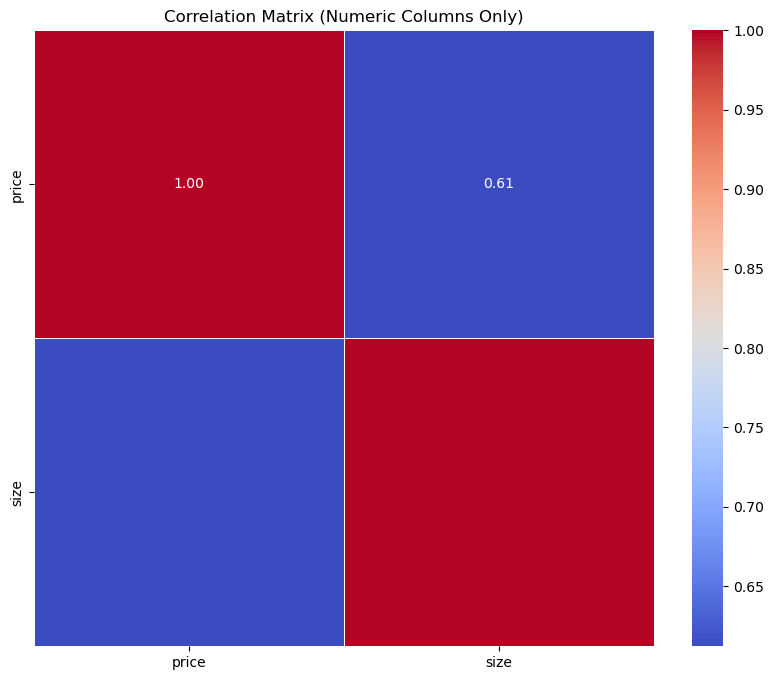

In [23]:
numeric_columns = train_df.select_dtypes(include=np.number)

corr_matrix = numeric_columns.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix (Numeric Columns Only)')
plt.show()

## Preprocessing

## MODELLLING

In [108]:
features = list(X_train.columns)
cat_features = []
text_features = ['desc']

cb_model = CatBoostRegressor(iterations=1000,
                             loss_function='RMSE',
                             eval_metric='R2',
                             depth = 7,

                             learning_rate=0.13)
cb_model.fit(X_train, y_train, cat_features=cat_features, text_features=text_features, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.0957724	total: 104ms	remaining: 1m 43s
1:	learn: 0.1643724	total: 186ms	remaining: 1m 32s
2:	learn: 0.2220781	total: 273ms	remaining: 1m 30s
3:	learn: 0.2761270	total: 351ms	remaining: 1m 27s
4:	learn: 0.3168657	total: 432ms	remaining: 1m 25s
5:	learn: 0.3526654	total: 510ms	remaining: 1m 24s
6:	learn: 0.3857466	total: 597ms	remaining: 1m 24s
7:	learn: 0.4178701	total: 704ms	remaining: 1m 27s
8:	learn: 0.4427729	total: 787ms	remaining: 1m 26s
9:	learn: 0.4599851	total: 868ms	remaining: 1m 25s
10:	learn: 0.4750085	total: 949ms	remaining: 1m 25s
11:	learn: 0.4921943	total: 1.05s	remaining: 1m 26s
12:	learn: 0.5147855	total: 1.14s	remaining: 1m 26s
13:	learn: 0.5273300	total: 1.22s	remaining: 1m 25s
14:	learn: 0.5435861	total: 1.29s	remaining: 1m 25s
15:	learn: 0.5500677	total: 1.37s	remaining: 1m 24s
16:	learn: 0.5610637	total: 1.45s	remaining: 1m 24s
17:	learn: 0.5696870	total: 1.54s	remaining: 1m 24s
18:	learn: 0.5824555	total: 1.65s	remaining: 1m 25s
19:	learn: 0.5931147	t

## Hyperparameter Tuning

In [54]:
# Define parameter random
param_random = {
    'depth': [4, 7, 9],
    'learning_rate': [0.1, 0.13, 0.15],
    'iterations': [100, 500, 1000],
    'l2_leaf_reg': [1, 3, 5]
}

# Create CatBoost model
cb_model = CatBoostRegressor(loss_function='RMSE',
                             eval_metric='R2',
                             cat_features=cat_features,
                             text_features=text_features)

# Perform random search
random_search = RandomizedSearchCV(estimator=cb_model, param_distributions=param_random, cv=5)
random_search.fit(X_train, y_train)

# Get best parameters and best score
best_params = random_search.best_params_
best_score = random_search.best_score_
print("Best Parameters:", best_params)
print("Best Score:", best_score)


## Cross Validation

In [ ]:
#cross validate
cv_dataset = Pool(data=X_train,
                  label=y_train,
                  cat_features=cat_features,
                  text_features=text_features
                  )

params = {"iterations": 100,
          "depth": 7,
          "learning_rate":0.13,
          'l2_leaf_reg': 1,
          "loss_function": "RMSE",
          "verbose": False,
          'eval_metric': 'R2'
          }

cv_scores = cv(cv_dataset,
            params,
            fold_count=10
            )

mean_r2_score = cv_scores['test-R2-mean'].iloc[-1]
print("Mean R2 Score:", mean_r2_score)

In [54]:
features = list(X_train.columns)
cat_features = ['type']
text_features = ['title_desc', 'desc']

cb_model = CatBoostRegressor(iterations=1000,
                             loss_function='RMSE',
                             eval_metric='R2',
                             depth = 7,
                             l2_leaf_reg = 1,
                             learning_rate=0.13)
cb_model.fit(X_train, y_train, cat_features=cat_features, text_features=text_features, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.0638148	total: 435ms	remaining: 7m 14s
1:	learn: 0.1270883	total: 720ms	remaining: 5m 59s
2:	learn: 0.1869080	total: 995ms	remaining: 5m 30s
3:	learn: 0.2356941	total: 1.27s	remaining: 5m 16s
4:	learn: 0.2730653	total: 1.55s	remaining: 5m 9s
5:	learn: 0.3102053	total: 1.86s	remaining: 5m 7s
6:	learn: 0.3433911	total: 2.13s	remaining: 5m 2s
7:	learn: 0.3761984	total: 2.42s	remaining: 5m
8:	learn: 0.3999647	total: 2.7s	remaining: 4m 57s
9:	learn: 0.4208170	total: 2.97s	remaining: 4m 53s
10:	learn: 0.4380635	total: 3.24s	remaining: 4m 51s
11:	learn: 0.4601431	total: 3.51s	remaining: 4m 48s
12:	learn: 0.4774624	total: 3.82s	remaining: 4m 50s
13:	learn: 0.4976861	total: 4.21s	remaining: 4m 56s
14:	learn: 0.5124466	total: 4.47s	remaining: 4m 53s
15:	learn: 0.5270334	total: 4.74s	remaining: 4m 51s
16:	learn: 0.5392413	total: 5.01s	remaining: 4m 49s
17:	learn: 0.5542309	total: 5.28s	remaining: 4m 47s
18:	learn: 0.5671244	total: 5.55s	remaining: 4m 46s
19:	learn: 0.5757723	total: 5.

## Model Prediction

In [109]:
y_pred = cb_model.predict(test_df)

In [110]:
y_pred.min(), y_pred.max()

(179.60316655974387, 469.1612443942616)

## Saving to CSV

In [123]:
pred_to_csv = pd.DataFrame({'id': range(len(y_pred)), 'price': y_pred.round(2)})

pred_to_csv.to_csv('solutionX3.csv', index=False)

best

In [ ]:
cb_model = CatBoostRegressor(iterations=1000,
                             loss_function='RMSE',
                             eval_metric='R2',
                             depth = 3,
                             colsample_bylevel=0.1,
                             max_ctr_complexity=1,
                             max_bin=32,
                             learning_rate=0.13)

In [121]:
y_train.min(), y_train.max()

(90.0, 500.0)

In [124]:
f = pd.read_csv('solution.csv')
f.price.min(), f.price.max()

(179.45, 465.83)

### ENSEMBLE

In [66]:
vectorizer = TfidfVectorizer(max_features=100)
numerical_features = ['size', 'distance_to_center']
cat_features = ['desc']
num_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

text_transformer = Pipeline(steps=[
    ('vectorizer', vectorizer)
])
column_transformer = ColumnTransformer(
    transformers=[
        ('num', num_transformer, numerical_features),
        ('text', text_transformer, 'desc')
    ]
)


In [72]:
model = XGBRegressor(n_estimators=1000, learning_rate=0.13, gamma=0, subsample=0.75,
                           colsample_bytree=1, max_depth=7, min_child_weight=8)
pipeline = Pipeline(steps=[('preprocessor', column_transformer),    
                            ('model', model)])
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['size',
                                                   'distance_to_center']),
                                                 ('text',
                                                  Pipeline(steps=[('vectorizer',
                                                                   TfidfVectorizer(max_features=100))]),
                                                  'desc')])),
                ('model',
                 XGBRegressor(base_score=None, booster=None, callbacks=None,
                              colsa...
                              feature_types=None, gamma=0, gpu_id=None,
                              grow_policy=None, importance_type=None,
                              interaction_constraints=None, learning_rate=0.13,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=7, max_leaves=None, min_child_weight=8,
                              missing=nan, monotone_constraints=None,
                              n_estimators=1000, n_jobs=None,
                              num_parallel_tree=None, predictor=None,
                              random_state=None, ...))])

In [73]:
y_pred_xg = pipeline.predict(test_df)

In [74]:
y_pred_xg.min()

182.14421

### Meta Features

In [92]:
meta_features = np.column_stack((y_pred, y_pred_xg))
meta_features

array([[336.16201201, 335.0980835 ],
       [371.62885932, 340.81820679],
       [289.06252585, 289.01779175],
       [387.1760553 , 368.34643555],
       [348.95582153, 366.47543335],
       [381.2867213 , 387.74954224],
       [345.93413271, 329.02142334],
       [256.87107892, 242.66586304],
       [304.8053819 , 304.9977417 ],
       [294.66549647, 295.02160645],
       [364.31664011, 364.60809326],
       [398.25271428, 361.46850586],
       [345.17193766, 365.33135986],
       [385.63730358, 352.83959961],
       [365.91119293, 357.69747925],
       [310.76956094, 245.9147644 ],
       [274.35818938, 311.18218994],
       [413.77924018, 429.49014282],
       [392.97632576, 394.56451416],
       [319.9150123 , 319.99765015],
       [333.25948857, 333.59359741],
       [346.35789381, 315.16616821],
       [243.25265759, 249.96948242],
       [408.40412885, 410.29324341],
       [208.0362895 , 260.86572266],
       [215.09985698, 215.09576416],
       [359.92209753, 384.86907959],
 

In [119]:
from sklearn.model_selection import KFold
base_models = [cb_model, pipeline]

# Define the number of folds for cross-validation
k = 10  # Adjust the number of folds as needed

# Initialize lists to store predictions from base models
base_model_predictions = []

# Initialize KFold cross-validator
kf = KFold(n_splits=k, shuffle=True, random_state=13)

# Iterate over each fold
for train_idx, val_idx in kf.split(X_train):
    # Split the data into training and validation sets for this fold
    X_train_fold, X_val_fold = X_train.iloc[train_idx], X_train.iloc[val_idx]
    X_train_xg_fold, X_val_xg_fold = X_train_xg.iloc[train_idx], X_train_xg.iloc[val_idx]
    y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]
    
    # Train base models on the training fold
    base_model_fold = []
    for model in base_models:
        if model == cb_model:
            base_model_fold.append(model.fit(X_train_fold, y_train_fold, cat_features=cat_features, text_features=text_features))
        elif model == pipeline:
            base_model_fold.append(model.fit(X_train_xg_fold, y_train_fold))
    
    # Make predictions on the validation fold using base models
    fold_predictions = np.column_stack([model.predict(X_val_fold) if model == cb_model else model.predict(X_val_xg_fold) for model in base_model_fold])
    
    # Append fold predictions to the list
    base_model_predictions.append(fold_predictions)

# Concatenate predictions from all folds
base_model_predictions = np.vstack(base_model_predictions)

# Train meta-learner on entire training set
meta_learner = LinearRegression()
meta_learner.fit(base_model_predictions, y_train)


0:	learn: 0.0704323	total: 87.9ms	remaining: 35.1s
1:	learn: 0.1330461	total: 160ms	remaining: 31.8s
2:	learn: 0.1766061	total: 234ms	remaining: 31s
3:	learn: 0.2250397	total: 303ms	remaining: 30s
4:	learn: 0.2639323	total: 373ms	remaining: 29.4s
5:	learn: 0.2992501	total: 451ms	remaining: 29.6s
6:	learn: 0.3269822	total: 520ms	remaining: 29.2s
7:	learn: 0.3570802	total: 588ms	remaining: 28.8s
8:	learn: 0.3730302	total: 655ms	remaining: 28.5s
9:	learn: 0.3899447	total: 722ms	remaining: 28.1s
10:	learn: 0.4148429	total: 794ms	remaining: 28.1s
11:	learn: 0.4328332	total: 866ms	remaining: 28s
12:	learn: 0.4497163	total: 937ms	remaining: 27.9s
13:	learn: 0.4660439	total: 1.01s	remaining: 27.8s
14:	learn: 0.4835078	total: 1.07s	remaining: 27.5s
15:	learn: 0.4991779	total: 1.14s	remaining: 27.4s
16:	learn: 0.5124571	total: 1.21s	remaining: 27.2s
17:	learn: 0.5246241	total: 1.27s	remaining: 27.1s
18:	learn: 0.5338543	total: 1.34s	remaining: 26.9s
19:	learn: 0.5461708	total: 1.44s	remaining: 2

LinearRegression()

In [129]:
base_model_predictions

(865, 2)

In [132]:
meta_pred = meta_learner.predict(meta_features)

In [134]:
meta_pred.min()

338.2308234680242

In [137]:
meta_learner1 = LinearRegression()
meta_learner1.fit(meta_features, y_pred)

LinearRegression()

In [138]:
# xgb_test_pred = xgb_model.predict(X_test)
# cb_test_pred = cb_model.predict(X_test)

# Create meta-features for test set
meta_features_test = np.column_stack((y_pred, y_pred_xg))

# Make ensemble predictions
ensemble_pred = meta_learner1.predict(meta_features_test)

In [140]:
ensemble_pred.max()

439.0090750160888

### Using Transformer Bertmodel

In [184]:
tokenizer = BertTokenizer.from_pretrained('dccuchile/bert-base-spanish-wwm-uncased')

def tokenize_text(text):
    return tokenizer.encode(text, add_special_tokens=True, max_length=128, truncation=True)

train_df['tokenized_text'] = train_df['desc'].apply(tokenize_text)

In [185]:
max_seq_length = 128  # Example max sequence length

# Pad or truncate sequences to max length
def pad_sequences(tokens):
    if len(tokens) > max_seq_length:
        tokens = tokens[:max_seq_length]
    elif len(tokens) < max_seq_length:
        tokens += [0] * (max_seq_length - len(tokens))  # Padding token ID is 0
    return tokens

train_df['tokenized_text'] = train_df['tokenized_text'].apply(pad_sequences)

In [16]:
train_df

,price,loc_string,type,desc,title_desc,size,bath,size_per_bed,tokenized_text
0,320.0,Barcelona - Sant Antoni,FLAT,piso en última planta a reformar en calle tall...,piso planta reformar calle taller plaza univer...,85,1.0,170.0,"[4, 5505, 1035, 2921, 5340, 1012, 22266, 1035,..."
1,335.0,Barcelona - Dreta de l´Eixample,FLAT,ubicado en la zona del camp de larpa cerca de ...,ubicado zona camp larpa cerca sagrado familia ...,65,1.0,130.0,"[4, 5206, 1035, 1032, 2911, 1081, 3548, 1009, ..."
2,330.0,Barcelona - Dreta de l´Eixample,FLAT,en pleno centro de barcelona justo al lado de ...,pleno centro barcelona justo rambla catalunya ...,77,1.0,154.0,"[4, 1035, 7420, 2391, 1009, 5779, 3258, 1074, ..."
3,435.0,Barcelona - Sant Antoni,FLAT,vivienda espaciosa en sant antoni cerca de pl ...,vivienda espaciós sant antoni cerca pl españa ...,96,2.0,288.0,"[4, 7830, 9377, 30956, 1035, 13728, 4856, 3096..."
4,410.0,Barcelona - Sagrada Família,FLAT,en el corazón de barcelona en una hermosa finc...,corazón barcelona hermoso finca principio sigl...,84,1.0,168.0,"[4, 1035, 1039, 2998, 1009, 5779, 1035, 1091, ..."
...,...,...,...,...,...,...,...,...,...
861,342.0,Barcelona - Navas,FLAT,hannanpiper real estate les presenta en exclus...,hannanpiper real estate presentar exclusiva pr...,115,1.0,345.0,"[4, 11924, 30959, 1674, 1307, 2570, 25060, 177..."
862,315.0,Barcelona - Navas,FLAT,oportunidad la casa agency vende vivienda en l...,oportunidad casa agency vender vivienda zona p...,82,1.0,246.0,"[4, 3227, 1032, 1635, 6884, 6096, 11916, 7830,..."
863,360.0,Barcelona - Navas,FLAT,piso totalmente reformado y a estrenar con muc...,piso totalmente reformado estrenar luz natural...,79,2.0,316.0,"[4, 5505, 4519, 30840, 1040, 1012, 7973, 1020,..."
864,270.0,Barcelona - Navas,FLAT,presentamos la oportunidad de comprar un bonit...,presentar oportunidad comprar bonito piso refo...,63,1.0,63.0,"[4, 26159, 1032, 3227, 1009, 4348, 1044, 6035,..."
